In [13]:
"""This is to see which EL methods get what entities"""

from wikification import *
import copy
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os
import json
from datetime import datetime

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# many different option for combonations of datasets for smaller tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]
#datasets = [{'name':'nopop', 'path':os.path.join(pathStrt,'nopop.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')},{'name':'nopop', 'path':os.path.join(pathStrt,'nopop.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')},{'name':'nopop', 'path':os.path.join(pathStrt,'nopop.json')}]
#datasets = [{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

# 'popular', 'context1', 'context2', 'word2vec', 'coherence', 'tagme'
methods = ['popular', 'context1', 'context2', 'word2vec', 'coherence']

if 'word2vec' in methods:
    try:
        word2vec
    except:
        word2vec = gensim_loadmodel('/users/cs/amaral/cgmdir/WikipediaClean5Negative300Skip10.Ehsan/WikipediaClean5Negative300Skip10')

verbose = True

maxCands = 20

performances = {}

# for each dataset, run all methods
for dataset in datasets:
    performances[dataset['name']] = {}
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines that contain proper ascii
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    
    # run each method on the data set
    for mthd in methods:
        print mthd
        print str(datetime.now()) + '\n'
        performances[dataset['name']][mthd] = []
        
        totalLines = 0
        lineNum = 0
        
        # each method tests all lines
        for line in dataLines:
            if verbose:
                print str(totalLines + 1)
            
            # get absolute text indexes and entity id of each given mention
            trueEntities = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True) # the ground truth
            
            oData = copy.deepcopy(line)
            
            # original split string with mentions given
            resultS = wikifyEval(copy.deepcopy(line), True, maxC = maxCands, method = mthd)

            offset = 0
            for i in range(0, len(trueEntities)):
                if i-offset >= len(resultS):
                    break
                if trueEntities[i][2] == resultS[i-offset][2]:
                    performances[dataset['name']][mthd].append(lineNum + i)
                if trueEntities[i][0] <> resultS[i-offset][0]:
                    offset += 1
                
            lineNum += len(trueEntities)
            
            if verbose:
                print 'So far: ' + str(len(performances[dataset['name']][mthd])) + '/' + str(lineNum)
            
            totalLines += 1

print performances

kore

popular
2017-06-27 17:17:55.147827

1
So far: 0/2
2
So far: 0/4
3
So far: 1/6
4
So far: 1/8
5
So far: 2/9
6
So far: 3/11
7
So far: 3/14
8
So far: 4/17
9
So far: 4/19
10
So far: 6/24
11
So far: 8/28
12
So far: 9/31
13
So far: 9/34
14
So far: 12/39
15
So far: 15/45
16
So far: 15/48
17
So far: 16/51
18
So far: 17/54
19
So far: 18/59
20
So far: 20/63
21
So far: 22/66
22
So far: 25/70
23
So far: 26/73
24
So far: 26/77
25
So far: 26/79
26
So far: 28/82
27
So far: 29/84
28
So far: 31/87
29
So far: 31/90
30
So far: 33/92
31
So far: 34/94
32
So far: 35/96
33
So far: 35/98
34
So far: 35/100
35
So far: 35/103
36
So far: 35/105
37
So far: 36/108
38
So far: 36/111
39
So far: 36/113
40
So far: 37/115
41
So far: 41/119
42
So far: 44/123
43
So far: 47/126
44
So far: 48/130
45
So far: 49/132
46
So far: 50/134
47
So far: 51/136
48
So far: 52/138
49
So far: 54/141
50
So far: 54/142
context1
2017-06-27 17:17:55.256511

1
So far: 1/2
2
So far: 2/4
3
So far: 3/6
4
So far: 3/8
5
So far: 4/9
6
So far: 4

In [14]:
from __future__ import division

print 'KORE: \n'
print 'popular: ' + str(len(performances['kore']['popular']))
print 'popular Unique: ' + str(len(set(performances['kore']['popular'])
                               - (set(performances['kore']['context2'])
                                 | set(performances['kore']['coherence'])
                                 | set(performances['kore']['context1'])
                                 | set(performances['kore']['word2vec']))))
print 'context1: ' + str(len(performances['kore']['context1']))
print 'context1 Unique: ' + str(len(set(performances['kore']['context1'])
                               - (set(performances['kore']['context2'])
                                 | set(performances['kore']['coherence'])
                                 | set(performances['kore']['popular'])
                                 | set(performances['kore']['word2vec']))))
print 'context2: ' + str(len(performances['kore']['context2']))
print 'context2 Unique: ' + str(len(set(performances['kore']['context2'])
                               - (set(performances['kore']['popular'])
                                 | set(performances['kore']['coherence'])
                                 | set(performances['kore']['context1'])
                                 | set(performances['kore']['word2vec']))))
print 'word2vec: ' + str(len(performances['kore']['word2vec']))
print 'word2vec Unique: ' + str(len(set(performances['kore']['word2vec'])
                               - (set(performances['kore']['context2'])
                                 | set(performances['kore']['coherence'])
                                 | set(performances['kore']['context1'])
                                 | set(performances['kore']['popular']))))
print 'coherence: ' + str(len(performances['kore']['coherence']))
print 'coherence Unique: ' + str(len(set(performances['kore']['coherence'])
                               - (set(performances['kore']['context2'])
                                 | set(performances['kore']['popular'])
                                 | set(performances['kore']['context1'])
                                 | set(performances['kore']['word2vec']))))
maxP = len(
        set(performances['kore']['coherence'])
      | set(performances['kore']['popular'])
      | set(performances['kore']['context1'])
      | set(performances['kore']['context2'])
      | set(performances['kore']['word2vec']))
print 'Max Possible: ' + str(maxP)
print 'Max Precision: ' + str(maxP/142)

print '\nAQUAINT: \n'
print 'popular: ' + str(len(performances['AQUAINT']['popular']))
print 'popular Unique: ' + str(len(set(performances['AQUAINT']['popular'])
                               - (set(performances['AQUAINT']['context2'])
                                 | set(performances['AQUAINT']['coherence'])
                                 | set(performances['AQUAINT']['context1'])
                                 | set(performances['AQUAINT']['word2vec']))))
print 'context1: ' + str(len(performances['AQUAINT']['context1']))
print 'context1 Unique: ' + str(len(set(performances['AQUAINT']['context1'])
                               - (set(performances['AQUAINT']['context2'])
                                 | set(performances['AQUAINT']['coherence'])
                                 | set(performances['AQUAINT']['popular'])
                                 | set(performances['AQUAINT']['word2vec']))))
print 'context2: ' + str(len(performances['AQUAINT']['context2']))
print 'context2 Unique: ' + str(len(set(performances['AQUAINT']['context2'])
                               - (set(performances['AQUAINT']['popular'])
                                 | set(performances['AQUAINT']['coherence'])
                                 | set(performances['AQUAINT']['context1'])
                                 | set(performances['AQUAINT']['word2vec']))))
print 'word2vec: ' + str(len(performances['AQUAINT']['word2vec']))
print 'word2vec Unique: ' + str(len(set(performances['AQUAINT']['word2vec'])
                               - (set(performances['AQUAINT']['context2'])
                                 | set(performances['AQUAINT']['coherence'])
                                 | set(performances['AQUAINT']['context1'])
                                 | set(performances['AQUAINT']['popular']))))
print 'coherence: ' + str(len(performances['AQUAINT']['coherence']))
print 'coherence Unique: ' + str(len(set(performances['AQUAINT']['coherence'])
                               - (set(performances['AQUAINT']['context2'])
                                 | set(performances['AQUAINT']['popular'])
                                 | set(performances['AQUAINT']['context1'])
                                 | set(performances['AQUAINT']['word2vec']))))
maxP = len(
        set(performances['AQUAINT']['coherence'])
      | set(performances['AQUAINT']['popular'])
      | set(performances['AQUAINT']['context1'])
      | set(performances['AQUAINT']['context2'])
      | set(performances['AQUAINT']['word2vec']))
print 'Max Possible: ' + str(maxP)
print 'Max Precision: ' + str(maxP/685)

print '\nMSNBC: \n'
print 'popular: ' + str(len(performances['MSNBC']['popular']))
print 'popular Unique: ' + str(len(set(performances['MSNBC']['popular'])
                               - (set(performances['MSNBC']['context2'])
                                 | set(performances['MSNBC']['coherence'])
                                 | set(performances['MSNBC']['context1'])
                                 | set(performances['MSNBC']['word2vec']))))
print 'context1: ' + str(len(performances['MSNBC']['context1']))
print 'context1 Unique: ' + str(len(set(performances['MSNBC']['context1'])
                               - (set(performances['MSNBC']['context2'])
                                 | set(performances['MSNBC']['coherence'])
                                 | set(performances['MSNBC']['popular'])
                                 | set(performances['MSNBC']['word2vec']))))
print 'context2: ' + str(len(performances['MSNBC']['context2']))
print 'context2 Unique: ' + str(len(set(performances['MSNBC']['context2'])
                               - (set(performances['MSNBC']['popular'])
                                 | set(performances['MSNBC']['coherence'])
                                 | set(performances['MSNBC']['context1'])
                                 | set(performances['MSNBC']['word2vec']))))
print 'word2vec: ' + str(len(performances['MSNBC']['word2vec']))
print 'word2vec Unique: ' + str(len(set(performances['MSNBC']['word2vec'])
                               - (set(performances['MSNBC']['context2'])
                                 | set(performances['MSNBC']['coherence'])
                                 | set(performances['MSNBC']['context1'])
                                 | set(performances['MSNBC']['popular']))))
print 'coherence: ' + str(len(performances['MSNBC']['coherence']))
print 'coherence Unique: ' + str(len(set(performances['MSNBC']['coherence'])
                               - (set(performances['MSNBC']['context2'])
                                 | set(performances['MSNBC']['popular'])
                                 | set(performances['MSNBC']['context1'])
                                 | set(performances['MSNBC']['word2vec']))))
maxP = len(
        set(performances['MSNBC']['coherence'])
      | set(performances['MSNBC']['popular'])
      | set(performances['MSNBC']['context1'])
      | set(performances['MSNBC']['context2'])
      | set(performances['MSNBC']['word2vec']))
print 'Max Possible: ' + str(maxP)
print 'Max Precision: ' + str(maxP/657)

KORE: 

popular: 54
popular Unique: 2
context1: 49
context1 Unique: 3
context2: 70
context2 Unique: 1
word2vec: 21
word2vec Unique: 2
coherence: 74
coherence Unique: 6
Max Possible: 96
Max Precision: 0.676056338028

AQUAINT: 

popular: 553
popular Unique: 19
context1: 473
context1 Unique: 5
context2: 506
context2 Unique: 5
word2vec: 288
word2vec Unique: 7
coherence: 379
coherence Unique: 6
Max Possible: 601
Max Precision: 0.877372262774

MSNBC: 

popular: 422
popular Unique: 4
context1: 391
context1 Unique: 5
context2: 421
context2 Unique: 5
word2vec: 266
word2vec Unique: 4
coherence: 404
coherence Unique: 20
Max Possible: 502
Max Precision: 0.764079147641


In [3]:


"""This code is for getting data on the performance of different entity generation methods."""

from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json


def generateCandidates1(textData, maxC, oText):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase.
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = getMentionSentence(oText, mention)
        context = escapeStringSolr(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
                
        # sort by frequency
        solrRes = sorted(solrRes, key = itemgetter(1), reverse = True)
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

def generateCandidates2(textData, maxC):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase (most frequent).
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    candidates = []
    
    for mention in textData['mentions']:
        results = sorted(anchor2concept(textData['text'][mention[0]]), key = itemgetter(1), 
                          reverse = True)
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

def generateCandidates3(textData, maxC):
    
    candidates = []
    
    for mention in textData['mentions']:
        anchors = anchor2concept(textData['text'][mention[0]])
        entities = []
        
        for anchor in anchors:
            wanchors = id2anchor(anchor[0]) # get all anchors of the id in this anchor
            totalFreq = 0
            for wanchor in wanchors:
                totalFreq += wanchor[1]
            
            entities.append([anchor[0], totalFreq])
        
        results = sorted(entities, key = itemgetter(1), reverse = True)
        
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

def generateCandidates5(textData, maxC):
    
    candidates = []
    #print textData['text']
    for mention in textData['mentions']:
        
        # get all concepts for the anchor
        concepts = anchor2concept(textData['text'][mention[0]])
        
        # get the ids as string for solr query
        strIds = ['id:' +  str(strId[0]) for strId in concepts]
        
        context = []
        
        for mention2 in textData['mentions']:
            if mention2 <> mention:
                context += escapeStringSolr(textData['text'][mention2[0]])
        context = " ".join(context)
        mentionStr = escapeStringSolr(textData['text'][mention[0]])
        
        # gets the relevancy scores of all of the given potential concepts
        addr = 'http://localhost:8983/solr/enwiki20160305/select'
        params={'fl':'id score', 'indent':'on', 'start': '0', 'rows': str(maxC),
                'fq':" ".join(strIds),
                'q':'text:('+context.encode('utf-8')+')^1 title:(' + mentionStr.encode('utf-8')+')^1.35',
                'wt':'json'}
        r = requests.get(addr, params = params)
        
        solrRes = []
        try:
            if not ('response' not in r.json()
                   or 'docs' not in r.json()['response']
                   or len(r.json()['response']['docs']) == 0):
                for doc in r.json()['response']['docs'][:maxC]:
                    freq = 0
                    for concept in concepts:
                        # find concept frequency
                        if concept[0] == int(doc['id']):
                            freq = concept[1]
                    solrRes.append([long(doc['id']), freq, doc['score']])
        except:
            solrRes = []
        
        #print '\nMention: ' + textData['text'][mention[0]]
        #for res in solrRes:
        #    print '[' + id2title(res[0]) + '] -> freq: ' + str(res[1]) + ', rel: ' + str(res[2])
        
        candidates.append(solrRes) # take up to maxC of the results
    
    return candidates

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}
           ]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 50
correctCands1 = {} # dictionary containing the amount of correct entities found at each index
correctCands2 = {} # dictionary containing the amount of correct entities found at each index
correctCands3 = {} # dictionary containing the amount of correct entities found at each index
correctCands4 = {} # dictionary containing the amount of correct entities found at each index
correctCands5 = {} # dictionary containing the amount of correct entities found at each index
correctCands6 = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCands1[str(i)] = 0
    correctCands2[str(i)] = 0
    correctCands3[str(i)] = 0
    correctCands4[str(i)] = 0
    correctCands5[str(i)] = 0
    correctCands6[str(i)] = 0

totalMentions = 0

notFounds = []

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
            
        cands1 = generateCandidates1(line, maxC, oText)
        cands2 = generateCandidates2(line, maxC)
        cands3 = generateCandidates3(line, maxC)
        cands4 = []
        for cands in cands1:
            cands4.append(sorted(cands, key = itemgetter(2), reverse = True))
        cands5 = generateCandidates5(line, maxC)
        cands6 = generateCandidates(line, maxC, hybrid=True)
        
        i = 0
        for cand in cands1:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands1[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands1['-1'] += 1
                
            i += 1
            
        i = 0
        for cand in cands2:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands2[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands2['-1'] += 1
                notFounds.append([line['text'][line['mentions'][i][0]], id2title(oMentions[i][2]), line['text']])
            i += 1
            
        i = 0
        for cand in cands3:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands3[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands3['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands4:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands4[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands4['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands5:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands5[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands5['-1'] += 1
            i += 1
            
        i = 0
        for cand in cands6:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    correctCands6[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                correctCands6['-1'] += 1
            i += 1
            
            
        totalLines += 1
        
clear_output()
for nf in notFounds:
    print str(nf) + '\n'
    
"""Some reasons for not getting any candidates from mentions (popular):
-Misspellings ('Queen Sirikit Natoinal Convention Center' in AQUAINT)
-Very Unclear ones ('Kennedy Example' in Kore, 'white rule' in AQUAINT)
-Simply never showing up ('South African Broadcasting Corp.' in AQUAINT, 'sanctions' in AQUAINT)
-Overly Complex ('First Union'->'Wachovia' because of a merger, in AQAINT)
-Bad Casing ('ANCHORAGE' in AQUAINT)
"""

"""How to deal with these
-If there are no or very few results from anchor2concept, the correct entity is usually
    one of the top few results from Solr.
-It seems that anything above a score of 19 is relatively reliable from Solr (with title boost 1.35).
-Fuzzy querry 4 or 5
"""

kore

1


KeyboardInterrupt: 

In [8]:
for ide in anchor2concept('EMP'):
    print id2title(ide[0]) + ' : ' + str(ide[1])
    
for ide in anchor2concept('Obama'):
    print 'entityid:' + str(ide[0])

Nuclear_electromagnetic_pulse : 5
EMP_Museum : 4
EMP : 7
Electron_microprobe : 1
Union_for_the_Mediterranean : 1
Erma_EMP : 3
Electromagnetic_pulse_in_fiction_and_popular_culture : 1
EMP_Merchandising : 2
Electromagnetic_pulse : 103
entityid:328670
entityid:534366
entityid:893798
entityid:929258
entityid:11134291
entityid:17775180
entityid:17881122
entityid:20082093
entityid:26460273
entityid:43083270


In [ ]:
"""The graphs generated in this cell is for showing how many correct entities
are at each position of different candidate generation methods, as well as how 
many correct entities are not in the candidates."""

candsPopRel = []
for i in range(-1,maxC):
    candsPopRel.append(correctCands1[str(i)])
    
candsPop = []
for i in range(-1,maxC):
    candsPop.append(correctCands2[str(i)])
    
candsPopPop = []
for i in range(-1,maxC):
    candsPopPop.append(correctCands3[str(i)])
    
candsRelSentence = []
for i in range(-1,maxC):
    candsRelSentence.append(correctCands4[str(i)])
    
candsRelMentions = []
for i in range(-1,maxC):
    candsRelMentions.append(correctCands5[str(i)])
    
candsHybrid = []
for i in range(-1,maxC):
    candsHybrid.append(correctCands6[str(1)])
    
x = range(-1, maxC)

print 'Total Mentions: ' + str(totalMentions)


plt.bar(x, candsPopRel, 0.5, color='red')
plt.xlabel('Most Popular of most Relevant Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands1[str(-1)])
print str(candsPopRel) + '\n\n'


plt.bar(x, candsPop, 0.5, color='orange')
plt.xlabel('Popularity v1 Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands2[str(-1)])
print str(candsPop) + '\n\n'


plt.bar(x, candsPopPop, 0.5, color='green')
plt.xlabel('Popularity v2 Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands3[str(-1)])
print str(candsPopPop) + '\n\n'


plt.bar(x, candsRelSentence, 0.5, color='blue')
plt.xlabel('Sentence Relevancy Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands4[str(-1)])
print str(candsRelSentence) + '\n\n'


plt.bar(x, candsRelMentions, 0.5, color='purple')
plt.xlabel('Mentions Relevancy Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands5[str(-1)])
print str(candsRelMentions) + '\n\n'


plt.bar(x, candsHybrid, 0.5, color='black')
plt.xlabel('Hybrid Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank')
plt.show()
print 'Misplaced: ' + str(correctCands6[str(-1)])
print str(candsHybrid) + '\n\n'

In [1]:
"""This is to generate data for seeing the popular candidate generation quality on each separate dataset"""
from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 20

totalMntsKore = 0
totalMntsAquaint = 0
totalMntsMsnbc = 0
totalMntsWiki = 0

correctCandsKore = {} # dictionary containing the amount of correct entities found at each index
correctCandsAquaint = {} # dictionary containing the amount of correct entities found at each index
correctCandsMsnbc = {} # dictionary containing the amount of correct entities found at each index
correctCandsWiki = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCandsKore[str(i)] = 0
    correctCandsAquaint[str(i)] = 0
    correctCandsMsnbc[str(i)] = 0
    correctCandsWiki[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        oText = " ".join(line['text'])
            
        cands = generateCandidates(line, maxC)
        
        i = 0
        for cand in cands:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    if dataset['name'] == 'kore':
                        correctCandsKore[str(j)] += 1
                    elif dataset['name'] == 'AQUAINT':
                        correctCandsAquaint[str(j)] += 1
                    elif dataset['name'] == 'MSNBC':
                        correctCandsMsnbc[str(j)] += 1
                    elif dataset['name'] == 'wiki5000':
                        correctCandsWiki[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                if dataset['name'] == 'kore':
                    correctCandsKore['-1'] += 1
                elif dataset['name'] == 'AQUAINT':
                    correctCandsAquaint['-1'] += 1
                elif dataset['name'] == 'MSNBC':
                    correctCandsMsnbc['-1'] += 1
                elif dataset['name'] == 'wiki5000':
                    correctCandsWiki['-1'] += 1
            i += 1
        
        totalLines += 1
    
    if dataset['name'] == 'kore':
        totalMntsKore = totalMentions
    elif dataset['name'] == 'AQUAINT':
        totalMntsAquaint = totalMentions
    elif dataset['name'] == 'MSNBC':
        totalMntsMsnbc = totalMentions
    elif dataset['name'] == 'wiki5000':
        totalMntsWiki = totalMentions
    
    totalMentions = 0
        
clear_output()

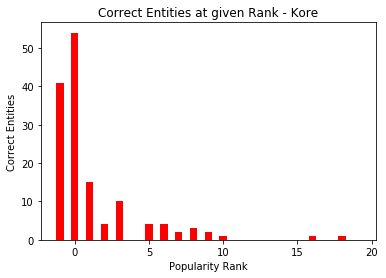

Kore Mentions: 142
Misplaced: 41
Portion Found: 0.711267605634
[41, 54, 15, 4, 10, 0, 4, 4, 2, 3, 2, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0]




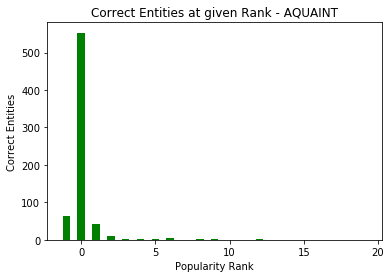

AQUAINT Mentions: 685
Misplaced: 63
Portion Found: 0.90802919708
[63, 553, 43, 9, 1, 2, 3, 5, 0, 3, 2, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]




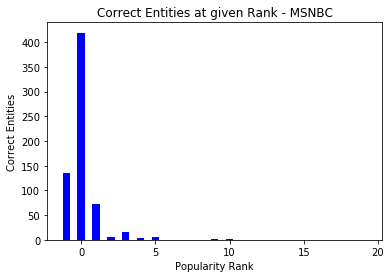

MSNBC Mentions: 657
Misplaced: 135
Portion Found: 0.794520547945
[135, 419, 72, 5, 15, 4, 5, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]




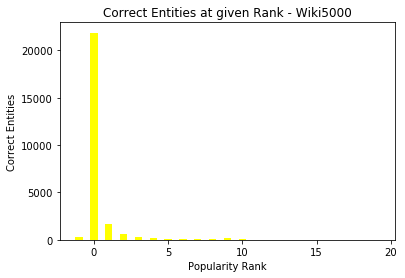

Wiki Mentions: 25608
Misplaced: 293
Portion Found: 0.988558263043
[293, 21870, 1693, 622, 286, 138, 111, 78, 97, 49, 147, 38, 30, 27, 28, 23, 22, 16, 18, 12, 10]




In [2]:
"""This is to visualize the popular candidate generation quality on each separate dataset"""

from __future__ import division

candsKore = []
for i in range(-1,maxC):
    candsKore.append(correctCandsKore[str(i)])

candsAquaint = []
for i in range(-1,maxC):
    candsAquaint.append(correctCandsAquaint[str(i)])
    
candsMsnbc = []
for i in range(-1,maxC):
    candsMsnbc.append(correctCandsMsnbc[str(i)])
    
candsWiki = []
for i in range(-1,maxC):
    candsWiki.append(correctCandsWiki[str(i)])
    
x = range(-1, maxC)

plt.bar(x, candsKore, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Kore')
plt.show()
print 'Kore Mentions: ' + str(totalMntsKore)
print 'Misplaced: ' + str(correctCandsKore[str(-1)])
print 'Portion Found: ' + str(1-correctCandsKore[str(-1)]/totalMntsKore)
print str(candsKore) + '\n\n'

plt.bar(x, candsAquaint, 0.5, color='green')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - AQUAINT')
plt.show()
print 'AQUAINT Mentions: ' + str(totalMntsAquaint)
print 'Misplaced: ' + str(correctCandsAquaint[str(-1)])
print 'Portion Found: ' + str(1-correctCandsAquaint[str(-1)]/totalMntsAquaint)
print str(candsAquaint) + '\n\n'

plt.bar(x, candsMsnbc, 0.5, color='blue')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - MSNBC')
plt.show()
print 'MSNBC Mentions: ' + str(totalMntsMsnbc)
print 'Misplaced: ' + str(correctCandsMsnbc[str(-1)])
print 'Portion Found: ' + str(1-correctCandsMsnbc[str(-1)]/totalMntsMsnbc)
print str(candsMsnbc) + '\n\n'

plt.bar(x, candsWiki, 0.5, color='yellow')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Wiki5000')
plt.show()
print 'Wiki Mentions: ' + str(totalMntsWiki)
print 'Misplaced: ' + str(correctCandsWiki[str(-1)])
print 'Portion Found: ' + str(1-correctCandsWiki[str(-1)]/totalMntsWiki)
print str(candsWiki) + '\n\n'

In [1]:
"""This is to generate data for seeing the context candidate generation quality on each separate dataset"""
from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json

def generateCandidates1(textData, maxC):
    """
    Description:
        Generates up to maxC candidates for each possible mention word in phrase.
    Args:
        textData: A text in split form along with its suspected mentions.
        maxC: The max amount of candidates to accept.
    Return:
        The top maxC candidates for each possible mention word in textData.
    """
    
    candidates = []
    ctxC = maxC
    for mention in textData['mentions']:
        results = []
        
        # get some context results from solr
        if ctxC > 0:
            mentionStr = escapeStringSolr(textData['text'][mention[0]])
            ctxStr = escapeStringSolr(getMentionsInSentence(textData, mention))
            
            strIds = ['-id:' +  str(res[0]) for res in results]
            
            # select all the docs from Solr with the best scores, highest first.
            addr = 'http://localhost:8983/solr/enwiki20160305/select'
            
            if len(ctxStr) == 0:
                params={'fl':'id', 'indent':'on', 'fq':" ".join(strIds),
                        'q':'title:(' + mentionStr.encode('utf-8')+')^2.35',
                        'wt':'json', 'rows':str(ctxC)}
            else:
                params={'fl':'id', 'indent':'on', 'fq':" ".join(strIds),
                        'q':'title:(' + mentionStr.encode('utf-8') + ')^2.35'
                        + ' text:(' + ctxStr.encode('utf-8') + ')',
                        'wt':'json', 'rows':str(ctxC)}
            
            r = requests.get(addr, params = params)
            try:
                if ('response' in r.json() 
                        and 'docs' in r.json()['response']
                        and len(r.json()['response']['docs']) > 0):
                    for doc in r.json()['response']['docs']:
                        results.append((long(doc['id']), 0))
            except:
                pass
            
        candidates.append(results[:maxC]) # take up to maxC of the results
    
    return candidates

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 20

totalMntsKore = 0
totalMntsAquaint = 0
totalMntsMsnbc = 0
totalMntsWiki = 0

correctCandsKore = {} # dictionary containing the amount of correct entities found at each index
correctCandsAquaint = {} # dictionary containing the amount of correct entities found at each index
correctCandsMsnbc = {} # dictionary containing the amount of correct entities found at each index
correctCandsWiki = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCandsKore[str(i)] = 0
    correctCandsAquaint[str(i)] = 0
    correctCandsMsnbc[str(i)] = 0
    correctCandsWiki[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
            
        cands = generateCandidates1(line, maxC)
        
        i = 0
        for cand in cands:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    if dataset['name'] == 'kore':
                        correctCandsKore[str(j)] += 1
                    elif dataset['name'] == 'AQUAINT':
                        correctCandsAquaint[str(j)] += 1
                    elif dataset['name'] == 'MSNBC':
                        correctCandsMsnbc[str(j)] += 1
                    elif dataset['name'] == 'wiki5000':
                        correctCandsWiki[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                if dataset['name'] == 'kore':
                    correctCandsKore['-1'] += 1
                elif dataset['name'] == 'AQUAINT':
                    correctCandsAquaint['-1'] += 1
                elif dataset['name'] == 'MSNBC':
                    correctCandsMsnbc['-1'] += 1
                elif dataset['name'] == 'wiki5000':
                    correctCandsWiki['-1'] += 1
            i += 1
        
        totalLines += 1
    
    if dataset['name'] == 'kore':
        totalMntsKore = totalMentions
    elif dataset['name'] == 'AQUAINT':
        totalMntsAquaint = totalMentions
    elif dataset['name'] == 'MSNBC':
        totalMntsMsnbc = totalMentions
    elif dataset['name'] == 'wiki5000':
        totalMntsWiki = totalMentions
    
    totalMentions = 0
        
clear_output()

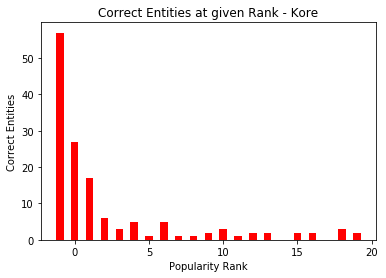

Kore Mentions: 142
Misplaced: 57
Portion Found: 0.598591549296
[57, 27, 17, 6, 3, 5, 1, 5, 1, 1, 2, 3, 1, 2, 2, 0, 2, 2, 0, 3, 2]




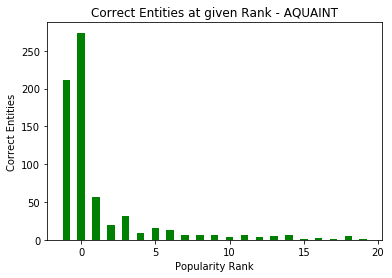

AQUAINT Mentions: 685
Misplaced: 212
Portion Found: 0.690510948905
[212, 274, 56, 20, 31, 9, 15, 13, 6, 6, 6, 4, 7, 4, 5, 7, 1, 2, 1, 5, 1]




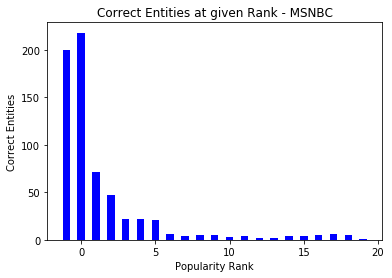

MSNBC Mentions: 657
Misplaced: 200
Portion Found: 0.695585996956
[200, 218, 71, 47, 22, 22, 21, 6, 4, 5, 5, 3, 4, 2, 2, 4, 4, 5, 6, 5, 1]




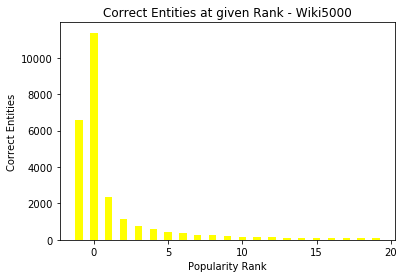

Wiki Mentions: 25608
Misplaced: 6600
Portion Found: 0.742268041237
[6600, 11382, 2339, 1135, 775, 609, 412, 363, 265, 263, 203, 164, 181, 165, 126, 118, 113, 106, 93, 105, 91]




In [2]:
"""This is to visualize the context candidate generation quality on each separate dataset"""

from __future__ import division

candsKore = []
for i in range(-1,maxC):
    candsKore.append(correctCandsKore[str(i)])

candsAquaint = []
for i in range(-1,maxC):
    candsAquaint.append(correctCandsAquaint[str(i)])
    
candsMsnbc = []
for i in range(-1,maxC):
    candsMsnbc.append(correctCandsMsnbc[str(i)])
    
candsWiki = []
for i in range(-1,maxC):
    candsWiki.append(correctCandsWiki[str(i)])
    
x = range(-1, maxC)

plt.bar(x, candsKore, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Kore')
plt.show()
print 'Kore Mentions: ' + str(totalMntsKore)
print 'Misplaced: ' + str(correctCandsKore[str(-1)])
print 'Portion Found: ' + str(1-correctCandsKore[str(-1)]/totalMntsKore)
print str(candsKore) + '\n\n'

plt.bar(x, candsAquaint, 0.5, color='green')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - AQUAINT')
plt.show()
print 'AQUAINT Mentions: ' + str(totalMntsAquaint)
print 'Misplaced: ' + str(correctCandsAquaint[str(-1)])
print 'Portion Found: ' + str(1-correctCandsAquaint[str(-1)]/totalMntsAquaint)
print str(candsAquaint) + '\n\n'

plt.bar(x, candsMsnbc, 0.5, color='blue')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - MSNBC')
plt.show()
print 'MSNBC Mentions: ' + str(totalMntsMsnbc)
print 'Misplaced: ' + str(correctCandsMsnbc[str(-1)])
print 'Portion Found: ' + str(1-correctCandsMsnbc[str(-1)]/totalMntsMsnbc)
print str(candsMsnbc) + '\n\n'

plt.bar(x, candsWiki, 0.5, color='yellow')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Wiki5000')
plt.show()
print 'Wiki Mentions: ' + str(totalMntsWiki)
print 'Misplaced: ' + str(correctCandsWiki[str(-1)])
print 'Portion Found: ' + str(1-correctCandsWiki[str(-1)]/totalMntsWiki)
print str(candsWiki) + '\n\n'

In [5]:
"""This is to generate data for seeing the hybrid candidate generation quality on each separate dataset"""
from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 20

totalMntsKore = 0
totalMntsAquaint = 0
totalMntsMsnbc = 0
totalMntsWiki = 0

correctCandsKore = {} # dictionary containing the amount of correct entities found at each index
correctCandsAquaint = {} # dictionary containing the amount of correct entities found at each index
correctCandsMsnbc = {} # dictionary containing the amount of correct entities found at each index
correctCandsWiki = {} # dictionary containing the amount of correct entities found at each index
for i in range(-1, maxC):
    correctCandsKore[str(i)] = 0
    correctCandsAquaint[str(i)] = 0
    correctCandsMsnbc[str(i)] = 0
    correctCandsWiki[str(i)] = 0

totalMentions = 0

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        
        oMentions = mentionStartsAndEnds(copy.deepcopy(line), forTruth = True)
        
        # get in right format
        line['mentions'] = mentionStartsAndEnds(line) # put mentions in right form
        #oText = " ".join(line['text'])
        
        cands = generateCandidates(line, maxC, True)
        
        i = 0
        for cand in cands:
            corCand = False
            for j in range(0, len(cand)):
                if cand[j][0] == oMentions[i][2]:
                    if dataset['name'] == 'kore':
                        correctCandsKore[str(j)] += 1
                    elif dataset['name'] == 'AQUAINT':
                        correctCandsAquaint[str(j)] += 1
                    elif dataset['name'] == 'MSNBC':
                        correctCandsMsnbc[str(j)] += 1
                    elif dataset['name'] == 'wiki5000':
                        correctCandsWiki[str(j)] += 1
                    corCand = True
                    break
            if corCand == False:
                if dataset['name'] == 'kore':
                    correctCandsKore['-1'] += 1
                elif dataset['name'] == 'AQUAINT':
                    correctCandsAquaint['-1'] += 1
                elif dataset['name'] == 'MSNBC':
                    correctCandsMsnbc['-1'] += 1
                elif dataset['name'] == 'wiki5000':
                    correctCandsWiki['-1'] += 1
            i += 1
        
        totalLines += 1
    
    if dataset['name'] == 'kore':
        totalMntsKore = totalMentions
    elif dataset['name'] == 'AQUAINT':
        totalMntsAquaint = totalMentions
    elif dataset['name'] == 'MSNBC':
        totalMntsMsnbc = totalMentions
    elif dataset['name'] == 'wiki5000':
        totalMntsWiki = totalMentions
    
    totalMentions = 0
    
clear_output()

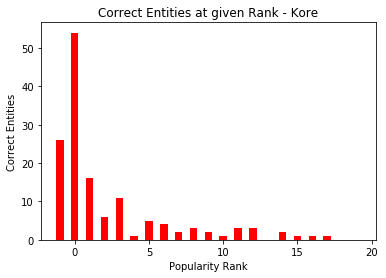

Kore Mentions: 142
Misplaced: 26
Portion Found: 0.816901408451
[26, 54, 16, 6, 11, 1, 5, 4, 2, 3, 2, 1, 3, 3, 0, 2, 1, 1, 1, 0, 0]




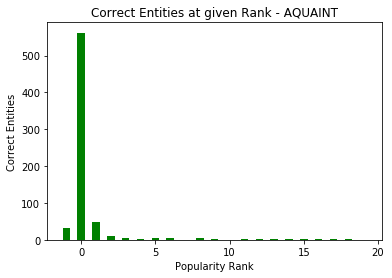

AQUAINT Mentions: 685
Misplaced: 32
Portion Found: 0.953284671533
[32, 562, 49, 9, 5, 3, 4, 5, 0, 4, 2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0]




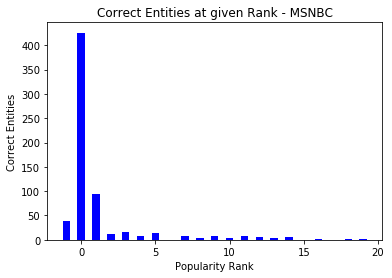

MSNBC Mentions: 657
Misplaced: 39
Portion Found: 0.940639269406
[39, 426, 95, 11, 17, 8, 14, 0, 7, 4, 8, 3, 7, 5, 4, 5, 0, 1, 0, 1, 2]




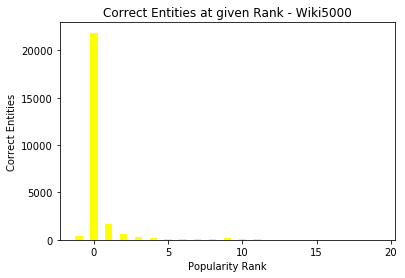

Wiki Mentions: 25608
Misplaced: 349
Portion Found: 0.986371446423
[349, 21870, 1693, 622, 286, 138, 111, 78, 97, 49, 147, 38, 51, 20, 13, 15, 7, 7, 5, 8, 4]




In [6]:
"""This is to visualize the hybrid candidate generation quality on each separate dataset"""

from __future__ import division

candsKore = []
for i in range(-1,maxC):
    candsKore.append(correctCandsKore[str(i)])

candsAquaint = []
for i in range(-1,maxC):
    candsAquaint.append(correctCandsAquaint[str(i)])
    
candsMsnbc = []
for i in range(-1,maxC):
    candsMsnbc.append(correctCandsMsnbc[str(i)])
    
candsWiki = []
for i in range(-1,maxC):
    candsWiki.append(correctCandsWiki[str(i)])
    
x = range(-1, maxC)

plt.bar(x, candsKore, 0.5, color='red')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Kore')
plt.show()
print 'Kore Mentions: ' + str(totalMntsKore)
print 'Misplaced: ' + str(correctCandsKore[str(-1)])
print 'Portion Found: ' + str(1-correctCandsKore[str(-1)]/totalMntsKore)
print str(candsKore) + '\n\n'

plt.bar(x, candsAquaint, 0.5, color='green')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - AQUAINT')
plt.show()
print 'AQUAINT Mentions: ' + str(totalMntsAquaint)
print 'Misplaced: ' + str(correctCandsAquaint[str(-1)])
print 'Portion Found: ' + str(1-correctCandsAquaint[str(-1)]/totalMntsAquaint)
print str(candsAquaint) + '\n\n'

plt.bar(x, candsMsnbc, 0.5, color='blue')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - MSNBC')
plt.show()
print 'MSNBC Mentions: ' + str(totalMntsMsnbc)
print 'Misplaced: ' + str(correctCandsMsnbc[str(-1)])
print 'Portion Found: ' + str(1-correctCandsMsnbc[str(-1)]/totalMntsMsnbc)
print str(candsMsnbc) + '\n\n'

plt.bar(x, candsWiki, 0.5, color='yellow')
plt.xlabel('Popularity Rank')
plt.ylabel('Correct Entities')
plt.title('Correct Entities at given Rank - Wiki5000')
plt.show()
print 'Wiki Mentions: ' + str(totalMntsWiki)
print 'Misplaced: ' + str(correctCandsWiki[str(-1)])
print 'Portion Found: ' + str(1-correctCandsWiki[str(-1)]/totalMntsWiki)
print str(candsWiki) + '\n\n'

In [1]:
"""This is to generate data on how our entity extraction performs in terms of quantity."""

from __future__ import division
from IPython.display import clear_output
import copy
from datetime import datetime
import tagme
import numpy as np
import matplotlib.pyplot as plt
from wikification import *
import os
import json

pathStrt = '/users/cs/amaral/wsd-datasets'
#pathStrt = 'C:\\Temp\\wsd-datasets'

# the data sets for performing on
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')},
            {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')},
            {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},
            {'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

# short for quick tests
#datasets = [{'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}]
#datasets = [{'name':'wiki5000', 'path':os.path.join(pathStrt,'wiki-mentions.5000.json')}]
datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')}]
#datasets = [{'name':'kore', 'path':os.path.join(pathStrt,'kore.json')}, {'name':'AQUAINT', 'path':os.path.join(pathStrt,'AQUAINT.txt.json')}, {'name':'MSNBC', 'path':os.path.join(pathStrt,'MSNBC.txt.json')},{'name':'wiki500', 'path':os.path.join(pathStrt,'wiki-mentions.500.json')}]

maxC = 1

avgMentions = {}
avgText = {}

theX = {}
theY = {}
myY = {}

for dataset in datasets:
    # get the data from dataset
    dataFile = open(dataset['path'], 'r')
    dataLines = []
    
    # put in all lines
    for line in dataFile:
        dataLines.append(json.loads(line.decode('utf-8').strip()))
        
    print dataset['name'] + '\n'
    #print str(datetime.now()) + '\n'
    totalLines = 0
    
    totalMentions = 0
    totalText = 0
    
    theX[dataset['name']] = []
    theY[dataset['name']] = []
    myY[dataset['name']] = []
    
    for line in dataLines: 
        print str(totalLines + 1)
        
        totalMentions += len(line['mentions'])
        totalText += len(line['text'])
        
        theX[dataset['name']].append(len(line['text']))
        theY[dataset['name']].append(len(line['mentions']))
        line = mentionExtract(" ".join(line['text']))
        myY[dataset['name']].append(len(line['mentions']))
        
        
        print 'Mentions: ' + str(len(line['mentions']))
        print 'Text: ' + str(len(line['text']))
        print len(line['mentions'])/len(line['text'])
        
        """print 'Text: ' + " ".join(line['text']) + '\n'
        
        print 'Actual Mentions:'
        for mention in line['mentions']:
            print line['text'][mention[0]]
            
        print '\nMy Mentions:'
        line = mentionExtract(" ".join(line['text']))
        for mention in line['mentions']:
            print line['text'][mention[0]]"""
        print '\n'
        
        totalLines += 1
        
    avgMentions[dataset['name']] = totalMentions/totalLines
    avgText[dataset['name']] = totalText/totalLines
    
clear_output()

print avgMentions
print avgText

{'kore': 2.84, 'MSNBC': 32.85, 'AQUAINT': 13.7}
{'kore': 14.36, 'MSNBC': 538.65, 'AQUAINT': 211.64}


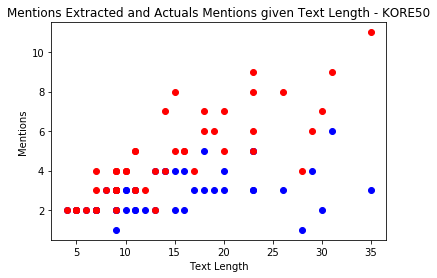

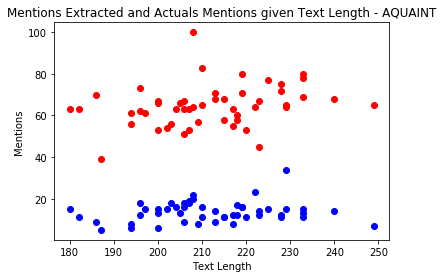

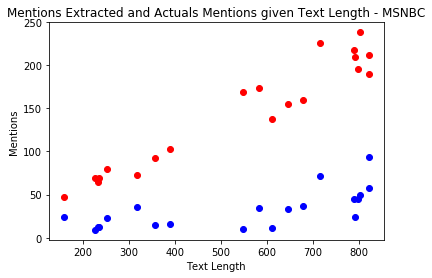

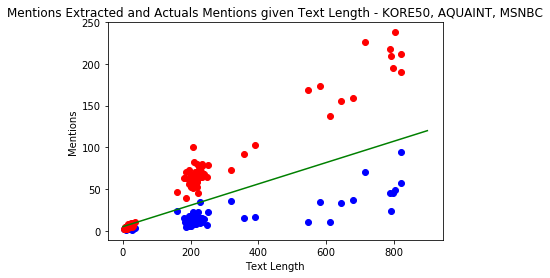

In [8]:
"""Visualizes the quantity of our mentions extracted."""

plt.plot(theX['kore'], theY['kore'], 'o', color = 'blue')
plt.plot(theX['kore'], myY['kore'], 'o', color = 'red')
plt.title('Mentions Extracted and Actuals Mentions given Text Length - KORE50')
plt.xlabel('Text Length')
plt.ylabel('Mentions')
plt.show()

plt.title('Mentions Extracted and Actuals Mentions given Text Length - AQUAINT')
plt.xlabel('Text Length')
plt.ylabel('Mentions')
plt.plot(theX['AQUAINT'], theY['AQUAINT'], 'o', color = 'blue')
plt.plot(theX['AQUAINT'], myY['AQUAINT'], 'o', color = 'red')
plt.show()

plt.title('Mentions Extracted and Actuals Mentions given Text Length - MSNBC')
plt.xlabel('Text Length')
plt.ylabel('Mentions')
plt.plot(theX['MSNBC'], theY['MSNBC'], 'o', color = 'blue')
plt.plot(theX['MSNBC'], myY['MSNBC'], 'o', color = 'red')
plt.show()

allX = []
allX.extend(theX['MSNBC'])
allX.extend(theX['AQUAINT'])
allX.extend(theX['kore'])

allTY = []
allTY.extend(theY['MSNBC'])
allTY.extend(theY['AQUAINT'])
allTY.extend(theY['kore'])

allMY = []
allMY.extend(myY['MSNBC'])
allMY.extend(myY['AQUAINT'])
allMY.extend(myY['kore'])

plt.title('Mentions Extracted and Actuals Mentions given Text Length - KORE50, AQUAINT, MSNBC')
plt.xlabel('Text Length')
plt.ylabel('Mentions')
plt.plot(allX, allTY, 'o', color = 'blue')
plt.plot(allX, allMY, 'o', color = 'red')
plt.plot((0,900),(5,120), color = 'green')
plt.show()


"""
Let x be the length of text and y be the amount of mention extracted.
y <= 5 + 0.12778x
"""